## Introduction

### Parameters

In [1]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
import threading
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.datasets import make_classification


%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
noises = [0, 0.3, 0.6, 0.9]

n_estimators = [15, 50, 100, 150, 250]
max_depth = [None, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.5]

stratified_k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
variance_threshold = VarianceThreshold()
scaler = StandardScaler()

model_name_map = { 'rf': 'Random Forest', 'gb': 'Gradient Boosting (XGB)' }

rf = RandomForestClassifier(class_weight='balanced', random_state=random_state, n_jobs=-1)
# gb = GradientBoostingClassifier(random_state=random_state)
gb = XGBClassifier(random_state=random_state, n_jobs=-1, colsample_bytree=0.7, subsample=0.8)

selector = SelectFromModel(rf, threshold='mean')

### Datasets splits and exploratory analysis

In [3]:
# read cancer data
X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y_cancer['x'] = Y_cancer['x'].map(label_map)

Y_cancer['x'].unique()

/tmp/ipykernel_46445/2119015477.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
/tmp/ipykernel_46445/2119015477.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


array([0, 1, 2, 3, 4, 5])

In [4]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

Y_cats_dogs['x'].unique()

array([0, 1])

In [5]:
# def splits(X, Y, gaussian_noise_factor=0, test_size=0.2, data_name='cancer'):
#     ''' Split into train and test. Includes noise and mislabeling. '''
#     X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
#     noise = np.random.normal(0, 1, X.shape)
    
#     # apply to all the columns of X the noise, without creating a new dataframe
#     X = pd.DataFrame(X.values + gaussian_noise_factor * noise, columns=X.columns, index=X.index)
        
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
#     return X_train, X_test, Y_train, Y_test
    
def splits(X, Y, noise_factor=0, test_size=0.2, data_name='cancer', validation_set=False, validation_size=0.2):
    ''' Split into train and test. Includes noise and mislabeling. '''
    if data_name == 'cats_dogs': # images case
        # Randomly select a subset of features (pixels) to set to random values
        # (the fraction of pixels to set to random values is given by "noise_factor")
        num_features = X.shape[1]
        num_noisy_features = int(noise_factor * num_features)
        noisy_features = np.random.choice(num_features, size=num_noisy_features, replace=False)
        
        # Set the selected features to random values
        X.iloc[:, noisy_features] = np.random.rand(X.shape[0], num_noisy_features)
    else: # tabular data case
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
        noise = np.random.normal(0, 1, X.shape)
        
        # Apply noise to all the columns of X without creating a new dataframe
        X = pd.DataFrame(X.values + noise_factor * noise, columns=X.columns, index=X.index)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_test, Y_train, Y_test

In [6]:
X_cats_dogs.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4087,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096
0,23,116,227,149,49,131,31,31,86,86,...,59,116,102,78,102,102,116,139,152,166
1,247,247,245,245,245,245,245,235,235,223,...,110,100,100,70,66,70,70,70,70,78
2,77,77,77,87,87,94,94,94,105,87,...,116,125,128,128,128,128,125,125,116,116
3,32,28,28,28,28,28,28,28,28,28,...,73,73,73,79,108,131,148,148,148,131
4,3,44,112,136,120,120,125,122,129,133,...,186,184,181,180,179,173,170,192,119,14


In [7]:
Y_cancer.value_counts()

x
1    1215
4     606
3     571
2     266
0     172
5      57
Name: count, dtype: int64

In [8]:
mask = Y_cancer['x'] == 'BC'
rows_index = Y_cancer.loc[mask].index
X_filtered = X_cancer.loc[rows_index]

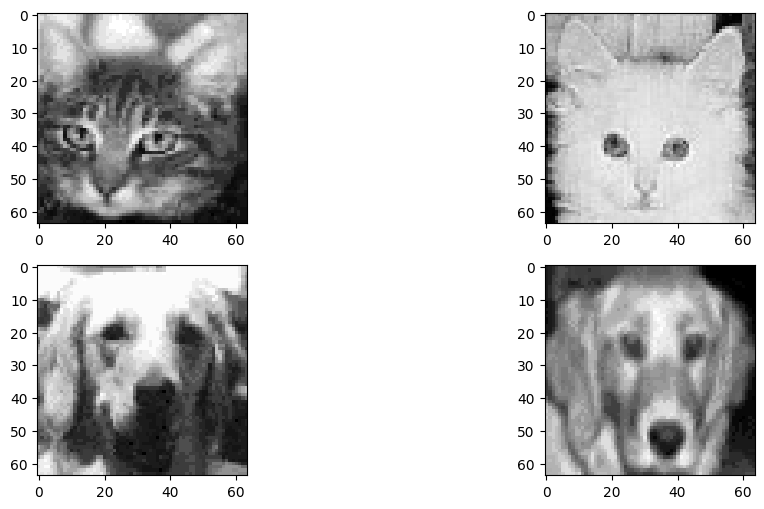

In [9]:
def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_images(indices, data, category, cmap='gray'):
    for idx, i in enumerate(indices):
        plt.subplot(2, 2, idx + 1 + category * 2)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.xlabel('')
        plt.ylabel('')

# random selections
ssc = np.random.choice(np.where(Y_cats_dogs == 0)[0], 2, replace=False)
ssd = np.random.choice(np.where(Y_cats_dogs == 1)[0], 2, replace=False)

plt.figure(figsize=(12, 6))
plot_images(ssc, X_cats_dogs, category=0)
plot_images(ssd, X_cats_dogs, category=1)
plt.show()

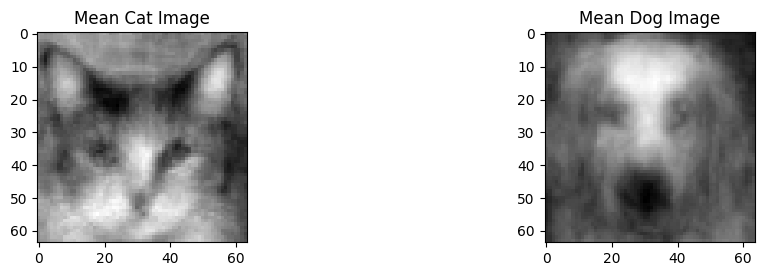

In [10]:
cat_indices = np.where(Y_cats_dogs == 0)[0]  # Indices of cats
dog_indices = np.where(Y_cats_dogs == 1)[0]  # Indices of dogs

mean_cat = np.mean(X_cats_dogs.iloc[cat_indices], axis=0)
mean_dog = np.mean(X_cats_dogs.iloc[dog_indices], axis=0)

mean_cat_image = rotateM(mean_cat.values.reshape(64, 64))
mean_dog_image = rotateM(mean_dog.values.reshape(64, 64))

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(mean_cat_image, cmap='gray')
plt.title('Mean Cat Image')
plt.subplot(2, 2, 2)
plt.imshow(mean_dog_image, cmap='gray')
plt.title('Mean Dog Image')
plt.show()

2024-04-29 14:43:56,084 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-29 14:43:56,089 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


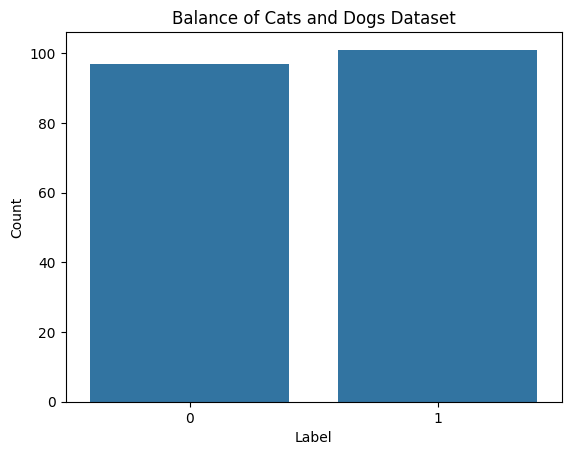

In [11]:
sns.countplot(data=Y_cats_dogs, x='x')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balance of Cats and Dogs Dataset')
plt.show()

## Setup

### Pipeline and grid search

In [12]:
# Parameter grid for Random Forest (bagging)
params_rf = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
}

# Parameter grid for Gradient Boosting
params_gb = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__learning_rate': learning_rate,
}

pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classifier', None)
])

def grid_search(X_train, Y_train, model: str):
    if model == 'rf':
        #pipeline.named_steps['feature_selection'].estimator_ = rf
        pipeline.steps[1] = ('classifier', rf)
        params = params_rf
    elif model == 'gb': 
        #pipeline.named_steps['feature_selection'].estimator_ = gb
        pipeline.steps[1] = ('classifier', gb)
        params = params_gb
    else:
        raise ValueError('Invalid model name')
    
    grid_search_res = GridSearchCV(pipeline, params, cv=stratified_k_fold, scoring='f1_macro', n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
        
    return grid_search_res

def get_feature_importance(grid_search_res, X):
    # feature importances from the best estimator
    best_estimator = grid_search_res.best_estimator_.named_steps['classifier']
    feature_importances = best_estimator.feature_importances_
    # feature names for features kept after filtering
    variance_threshold = grid_search_res.best_estimator_.named_steps['variance_threshold']
    
    feature_names = X.columns[variance_threshold.get_support()]

    # dataframe for feature importances
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    top_10_features = feature_importance_df.sort_values('importance', ascending=False).head(10)

    return feature_importance_df, top_10_features

### Plots and displays

In [13]:
def plot_learning_trend(grid_search_res, model_name, noise, data='cancer'):
    results = grid_search_res.cv_results_
    
    # mean test scores for each estimator with the same value of n_estimators
    mean_scores = []
    for n in n_estimators:
        mask = results['param_classifier__n_estimators'] == n
        if np.any(mask):
            mean_scores.append(np.mean(results['mean_test_score'][mask]))
        else:
            mean_scores.append(np.nan)
    
    plt.figure(figsize=(8, 6))
    plt.plot(n_estimators, mean_scores, marker='o')
    plt.xlabel('n estimators')
    plt.ylabel('cv score')
    plt.title(f'Learning trend for different n_estimators (model: {model_name_map[model_name]}, data: {data}, {noise * 100}% noise)')
    plt.grid(True)
    plt.savefig(f"imgs_{data}/{model_name}_plot_n_estimators_noise_{noise}.png")
    plt.show()

def plot_max_depth(grid_search_res, model_name, noise, data='cancer'):
    results = grid_search_res.cv_results_
    
    plt.figure(figsize=(8, 6))
    for d in max_depth:
        mask_d = results['param_classifier__max_depth'] == d
        mean_scores = []
        std_scores = []
        for n in n_estimators:
            mask_n = results['param_classifier__n_estimators'] == n
            mask = mask_d & mask_n
            if np.any(mask):
                mean_scores.append(np.mean(results['mean_test_score'][mask]))
                std_scores.append(np.std(results['mean_test_score'][mask]))
            else:
                mean_scores.append(np.nan)
                
        plt.plot(n_estimators, mean_scores, marker='o', label=f'max_depth={d}')
        plt.fill_between(n_estimators, np.array(mean_scores) - np.array(std_scores), np.array(mean_scores) + np.array(std_scores), alpha=0.2)
        
    plt.xlabel('n_estimators')
    plt.ylabel('cv score')
    plt.title(f'Learning trend for different max_depth (model: {model_name_map[model_name]}, data: {data}, {noise * 100}% noise)')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"imgs_{data}/{model_name}_plot_max_depth_noise_{noise}.png")
    plt.show()
    
def plot_confusion_matrix(Y_test, Y_test_pred, labels, model_name, noise, data='cancer'):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_test_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix (model: {model_name_map[model_name]}, data: {data}, {noise * 100}% noise)')
  plt.savefig(f"imgs_{data}/{model_name}_confusion_matrix_noise_{noise}.png")
  plt.show()
  
def show_classification_report(X_test, Y_test, grid_search_res, model_name: str, noise, data='cancer'):
  Y_test_pred = grid_search_res.predict(X_test)
  best_params = grid_search_res.best_params_
  print(f"Classification Report (data={data})\nOptimal parameters {best_params} (model: {model_name_map[model_name]}, data: {data}, noise: {noise * 100}%)\n",
      classification_report(Y_test, Y_test_pred)) 

def show_feature_importance(top_10_features, model_name: str, noise: float, data='cancer'):
    plt.figure(figsize=(8, 6))
    plt.bar(top_10_features['feature'], top_10_features['importance'], color='steelblue')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Top 10 Features (model: {model_name_map[model_name]}, data: {data}, {noise * 100:.1f}% Noise)')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(f"imgs_{data}/{model_name}_top_10_features_noise_{noise}.png", bbox_inches='tight')
    plt.show()
    
def plot_2_top_features(top_10_features, labels, X, Y, model_name: str, noise: float, data='cancer'):
    # 2 most important features
    top_2_features = top_10_features['feature'].head(2).values
    # colormap
    cmap = plt.get_cmap('viridis')
    class_colors = cmap(np.linspace(0, 1, len(labels)))
    
    # check if X and Y have the same indices
    assert (X.index == Y.index).all()
    assert len(X) == len(Y)
    
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(labels):
        mask = Y['x'] == cls
        indices = np.array(Y.loc[mask].index)

        valid_indices_mask = np.in1d(indices, X.index)
        if not valid_indices_mask.all():
            raise ValueError("Some indices in `indices` are out of bounds for `X`.")

        X_filtered = X.loc[indices[valid_indices_mask]]

        plt.scatter(
            # filter rows and select top column
            X_filtered[top_2_features[0]],
            X_filtered[top_2_features[1]],
            color=class_colors[i],
            label=f'Class {cls}',
            alpha=0.7
        )

    plt.xlabel(top_2_features[0])
    plt.ylabel(top_2_features[1])
    plt.title(f'Class Division with Top 2 Features (model: {model_name_map[model_name]}, data: {data}, {noise * 100:.1f}% Noise)')
    plt.legend()
    plt.savefig(f"imgs_{data}/{model_name}_class_division_top_2_features_noise_{noise}.png", bbox_inches='tight')
    plt.show()

def ranking_of_pixels(feature_importance_df,model_name: str, noise: float, data='cancer'):
    # feature importance values
    feature_importances = feature_importance_df['importance'].values
    image_shape = (64, 64) 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #cat
    axes[0].imshow(feature_importances.reshape(image_shape), cmap=plt.cm.Blues)
    axes[0].imshow(mean_cat_image, cmap='gray', alpha=0.5)
    # dog
    heatmap2 = axes[1].imshow(feature_importances.reshape(image_shape), cmap=plt.cm.Blues)
    axes[1].imshow(mean_dog_image, cmap='gray', alpha=0.5)
    # colorbar
    fig.colorbar(heatmap2, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
    plt.suptitle(f'Pixel Importance Ranking (model: {model_name_map[model_name]}, data: {data}, {noise * 100:.1f}% Noise)')
    plt.subplots_adjust(right=0.8)
    plt.savefig(f"imgs_{data}/{model_name}_pixel_importance_noise_{noise}.png", bbox_inches='tight')
    plt.show()
    
def plot_noise_effect(cv_scores, test_scores, model_name, data):
    ''' As a function of increasing noise, plot of the cv and test f1 score
    to show the gap between them. '''
    plt.figure(figsize=(8, 6))
    
    plt.plot(noises, cv_scores, marker='o', label='cv')
    plt.plot(noises, test_scores, marker='o', label='test')
    plt.xlabel('Noise')
    plt.ylabel('F1 macro Score')
    plt.title(f'F1 macro Score as a function of noise (model: {model_name_map[model_name]}, data: {data}, data: {data})')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"imgs_{data}/{model_name}_plot_noise_effect.png")
    plt.show()
            
def plot_learning_rates(grid_search_res, noise, data='cancer'):
    results = grid_search_res.cv_results_
    
    plt.figure(figsize=(8, 6))
    for l in learning_rate:
        mask_l = results['param_classifier__learning_rate'] == l
        mean_scores = []
        std_scores = []
        for n in n_estimators:
            mask_n = results['param_classifier__n_estimators'] == n
            mask = mask_l & mask_n
            if np.any(mask):
                mean_scores.append(np.mean(results['mean_test_score'][mask]))
                std_scores.append(np.std(results['mean_test_score'][mask]))
            else:
                mean_scores.append(np.nan)
        print(l, mean_scores)
        plt.plot(n_estimators, mean_scores, marker='o', label=f'learning rate={l}')
        plt.fill_between(n_estimators, np.array(mean_scores) - np.array(std_scores), np.array(mean_scores) + np.array(std_scores), alpha=0.2)
        
    plt.xlabel('n_estimators')
    plt.ylabel('f1 score macro')
    plt.title(f'Learning trend for different learning rates (model: {model_name_map['gb']}, data: {data}, {noise * 100}% noise)')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"imgs_{data}/gb_plot_learning_rates_{noise}.png")
    plt.show()

### Main processes

In [14]:
def process_noise(model_name, noise, data='cancer'):
    # split dataset
    if data == 'cancer':
        X_train, X_test, Y_train, Y_test = splits(X_cancer, Y_cancer, noise)
        labels = Y_cancer['x'].unique()
    elif data == 'cats_dogs':
        X_train, X_test, Y_train, Y_test = splits(X_cats_dogs, Y_cats_dogs, noise)
        labels = Y_cats_dogs['x'].unique()
    else:
        raise ValueError('Invalid data name')
    
    # grid search and metrics
    grid_search_res = grid_search(X_train, Y_train, model_name)
    balanced_ac_score = balanced_accuracy_score(Y_test, grid_search_res.predict(X_test))
    f1_scores = f1_score(Y_test, grid_search_res.predict(X_test), average='macro')
    
    # show results
    with print_lock:
        plot_learning_trend(grid_search_res, model_name, noise, data)
        show_classification_report(X_test, Y_test, grid_search_res, model_name, noise, data)
        plot_confusion_matrix(Y_test, grid_search_res.predict(X_test), labels, model_name, noise, data)
        plot_max_depth(grid_search_res, model_name, noise, data)
        
        if model_name == 'gb':
            plot_learning_rates(grid_search_res, noise, data)
        feature_importance_df, top_10_features = get_feature_importance(grid_search_res, X_train)
        if data == 'cancer':
            show_feature_importance(top_10_features, model_name, noise, data)
            plot_2_top_features(top_10_features, labels, X_train, Y_train, model_name, noise, data)
        if data == 'cats_dogs':
            ranking_of_pixels(feature_importance_df, model_name, noise, data)
    
    return {'noise': noise, 'grid_search_res': grid_search_res, 'balanced_ac_score': balanced_ac_score, 'f1_score': f1_scores}

In [15]:
def main_parallel(model_name: str, data='cancer'):
    logging.info(f'Starting main function with model_name: {model_name}')
    
    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for noise in noises:
            logging.info(f'Submitting task for noise level: {noise}')
            future = executor.submit(process_noise, model_name, noise, data)
            futures.append(future)
        
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            result = future.result()
            results.append(result)
            logging.info(f'Task {i + 1} completed with result: {result}')
            
        # print a summary with all the reuslts obtianed
        results = sorted(results, key=lambda x: x['noise'], reverse=True)
        logging.info('Summary of results:')
        for result in results:
            logging.info(f'Noise: {result["noise"]}, Balanced Accuracy Score: {result["balanced_ac_score"]}, F1 Score: {result["f1_score"]}')
            
        # best cv score for each noise level
        plot_noise_effect([result['grid_search_res'].best_score_ for result in results], [result['f1_score'] for result in results], model_name, data)
            
                
    logging.info('All tasks completed.')
    
    return results

## Test

2024-04-29 14:43:56,189 - INFO - Starting main function with model_name: rf
2024-04-29 14:43:56,190 - INFO - Submitting task for noise level: 0
2024-04-29 14:43:56,191 - INFO - Submitting task for noise level: 0.3
2024-04-29 14:43:56,197 - INFO - Submitting task for noise level: 0.6
2024-04-29 14:43:56,213 - INFO - Submitting task for noise level: 0.9


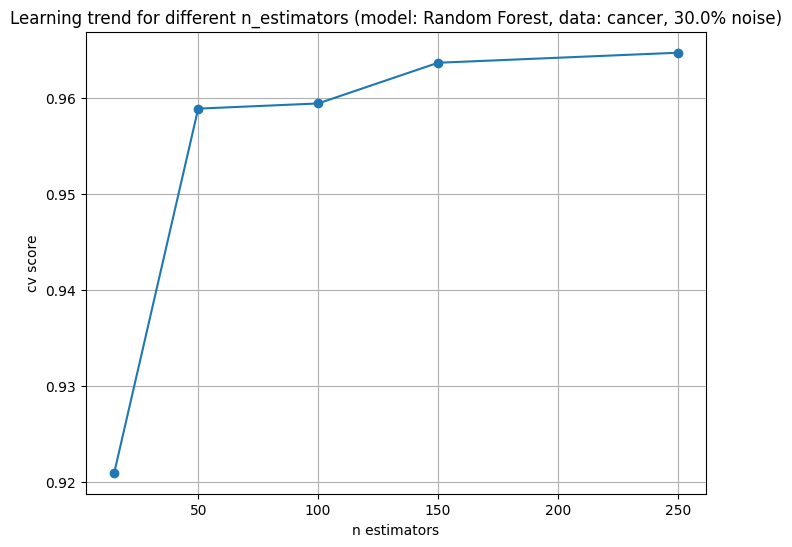

Classification Report (data=cancer)
Optimal parameters {'classifier__max_depth': 5, 'classifier__n_estimators': 150} (model: Random Forest, data: cancer, noise: 30.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      0.98      0.99       121
           5       1.00      0.92      0.96        12

    accuracy                           0.99       578
   macro avg       1.00      0.98      0.99       578
weighted avg       0.99      0.99      0.99       578



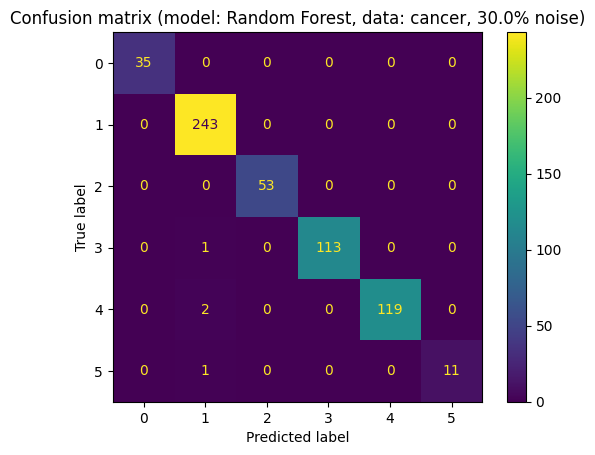

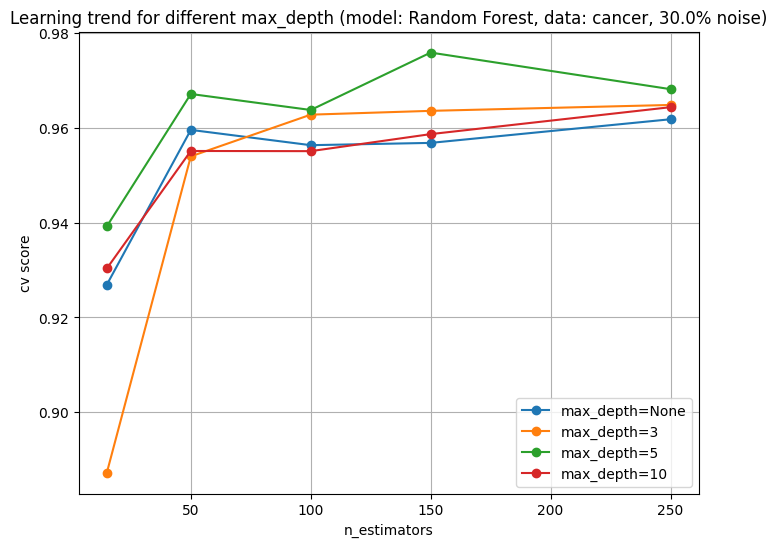

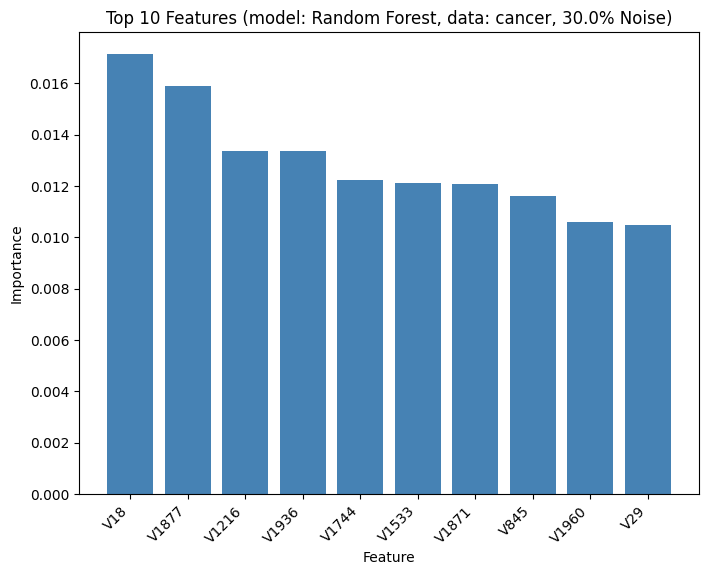

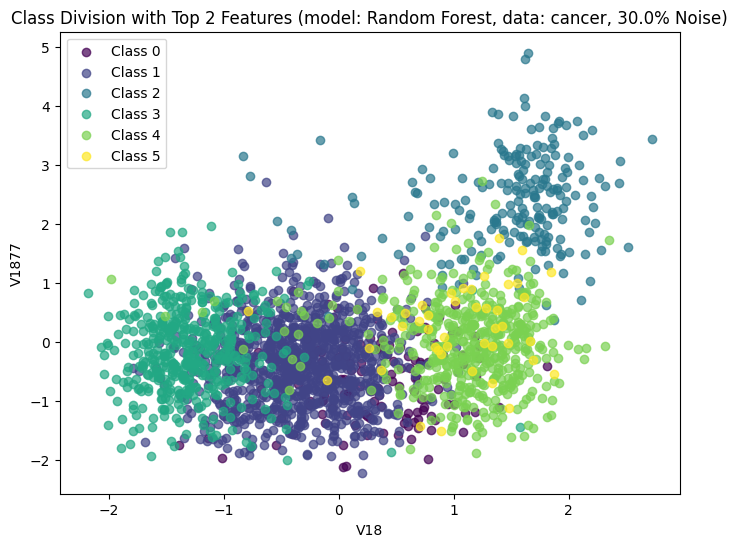

2024-04-29 14:45:46,250 - INFO - Task 1 completed with result: {'noise': 0.3, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.9818943018703785, 'f1_score': 0.9892699756912277}


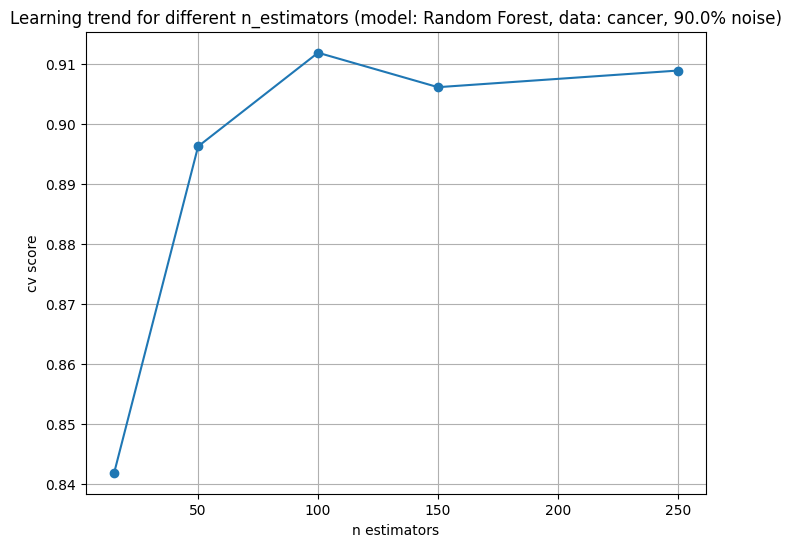

Classification Report (data=cancer)
Optimal parameters {'classifier__max_depth': 5, 'classifier__n_estimators': 250} (model: Random Forest, data: cancer, noise: 90.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       0.95      1.00      0.97        53
           3       1.00      0.97      0.99       114
           4       1.00      0.98      0.99       121
           5       1.00      0.75      0.86        12

    accuracy                           0.98       578
   macro avg       0.99      0.95      0.97       578
weighted avg       0.98      0.98      0.98       578



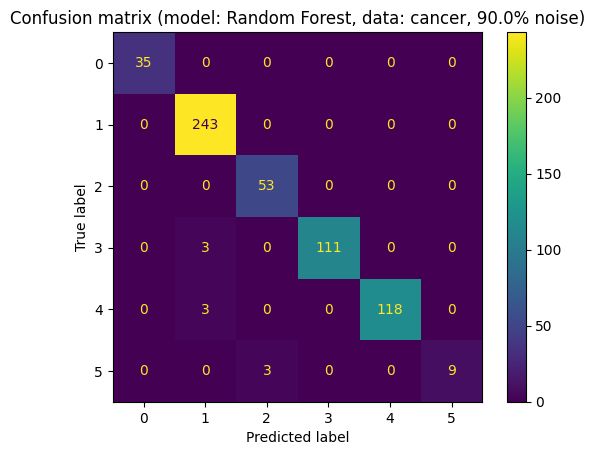

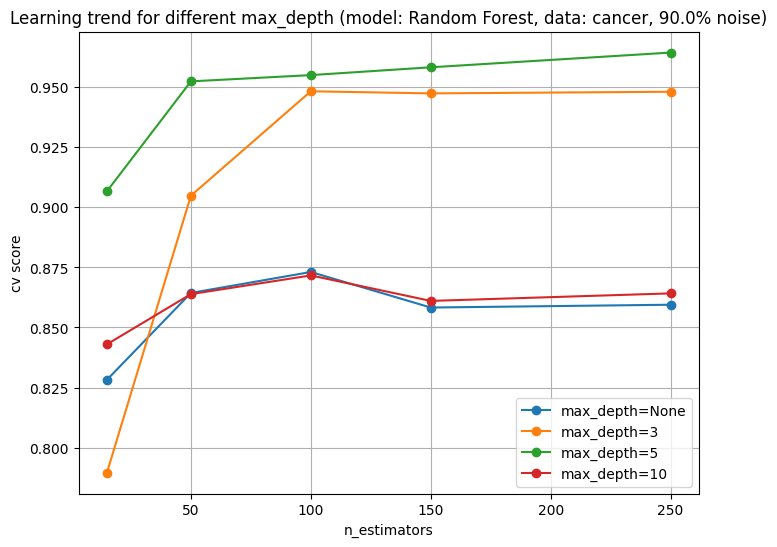

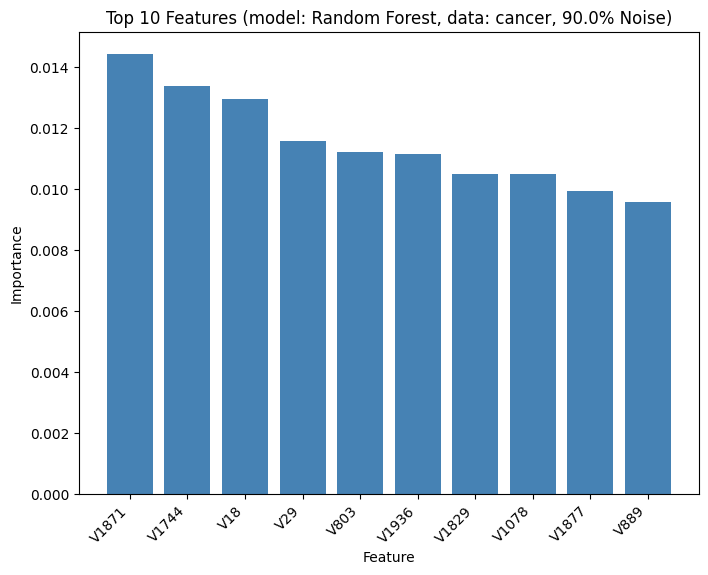

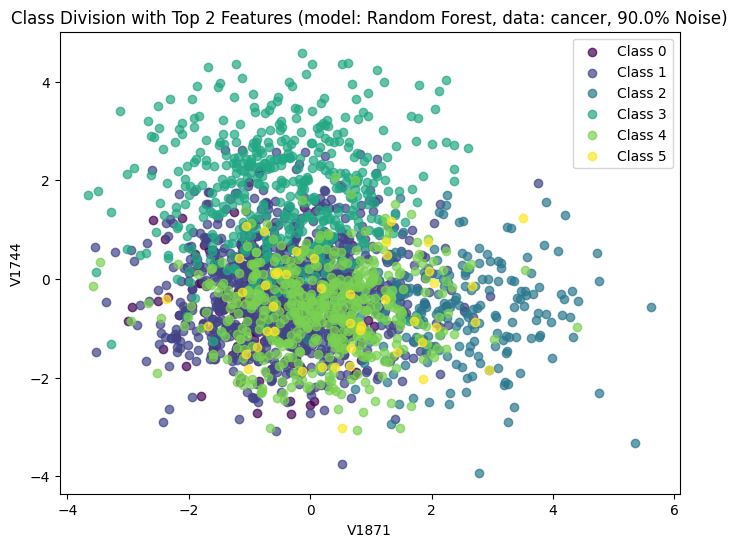

2024-04-29 14:45:47,391 - INFO - Task 2 completed with result: {'noise': 0.9, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.949815137016094, 'f1_score': 0.9652565274705429}


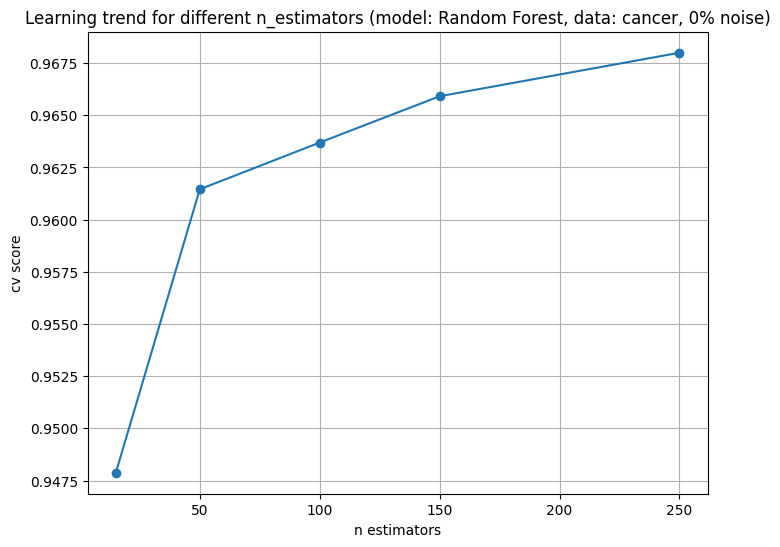

Classification Report (data=cancer)
Optimal parameters {'classifier__max_depth': 5, 'classifier__n_estimators': 250} (model: Random Forest, data: cancer, noise: 0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.99      1.00      1.00       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      0.99      1.00       121
           5       1.00      1.00      1.00        12

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



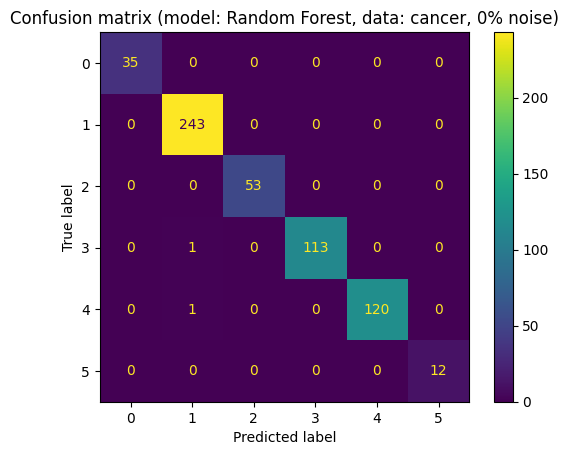

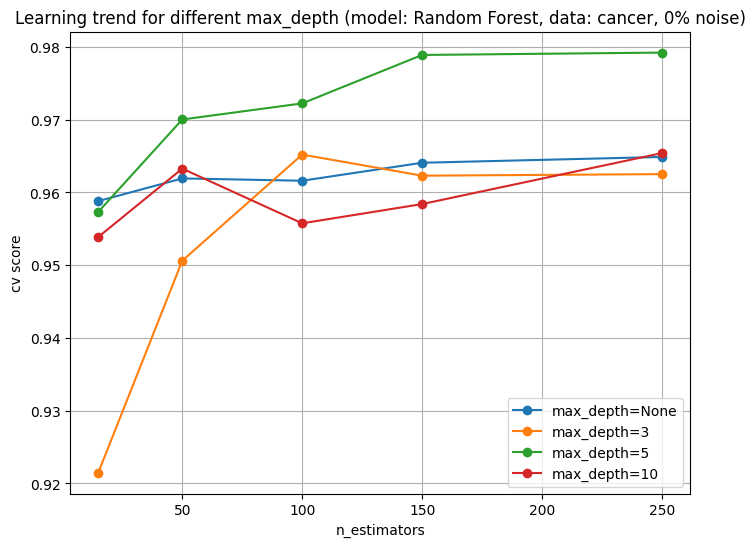

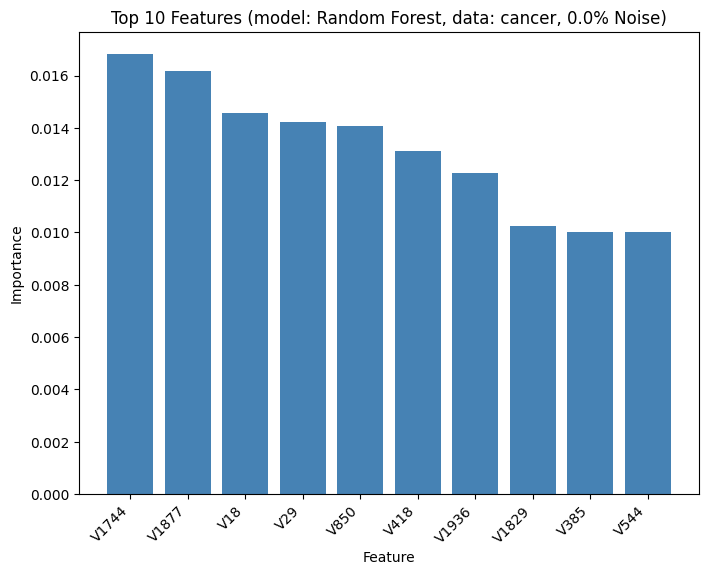

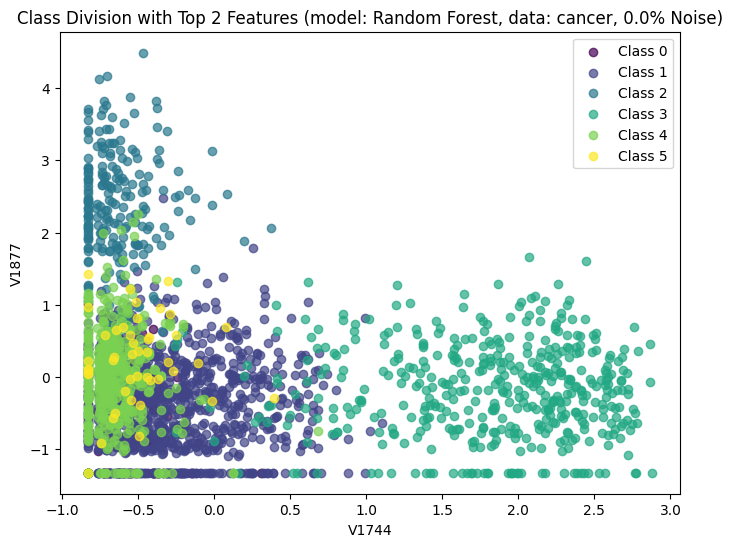

2024-04-29 14:45:48,567 - INFO - Task 3 completed with result: {'noise': 0, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.9971606012275869, 'f1_score': 0.9978911625678815}


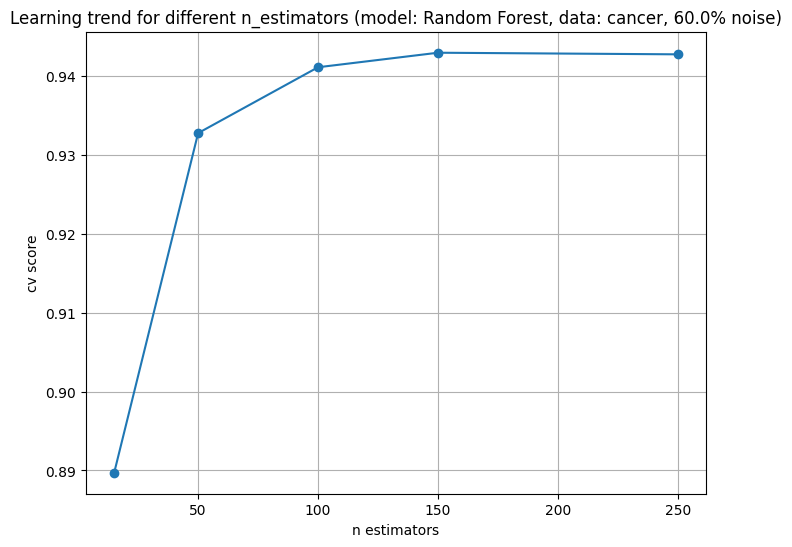

Classification Report (data=cancer)
Optimal parameters {'classifier__max_depth': 5, 'classifier__n_estimators': 250} (model: Random Forest, data: cancer, noise: 60.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       0.96      1.00      0.98        53
           3       1.00      0.99      1.00       114
           4       1.00      0.98      0.99       121
           5       1.00      0.75      0.86        12

    accuracy                           0.99       578
   macro avg       0.99      0.95      0.97       578
weighted avg       0.99      0.99      0.99       578



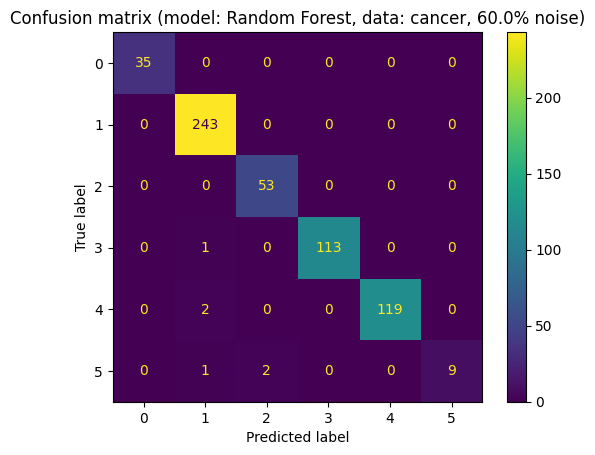

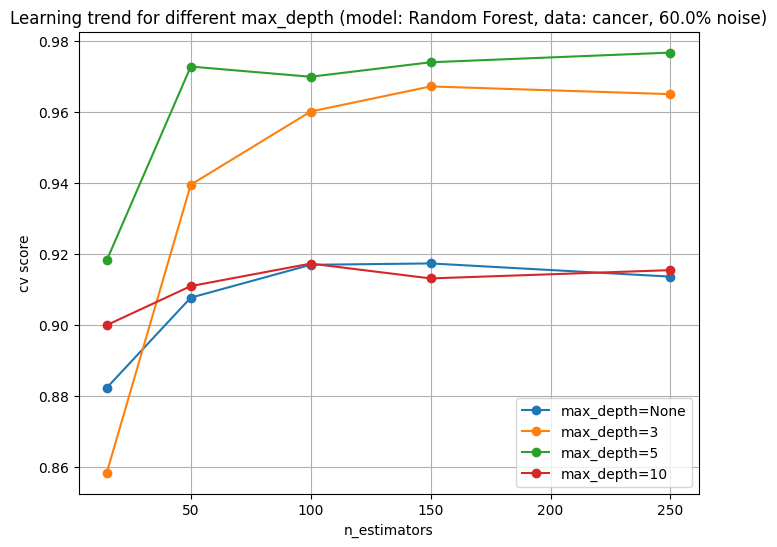

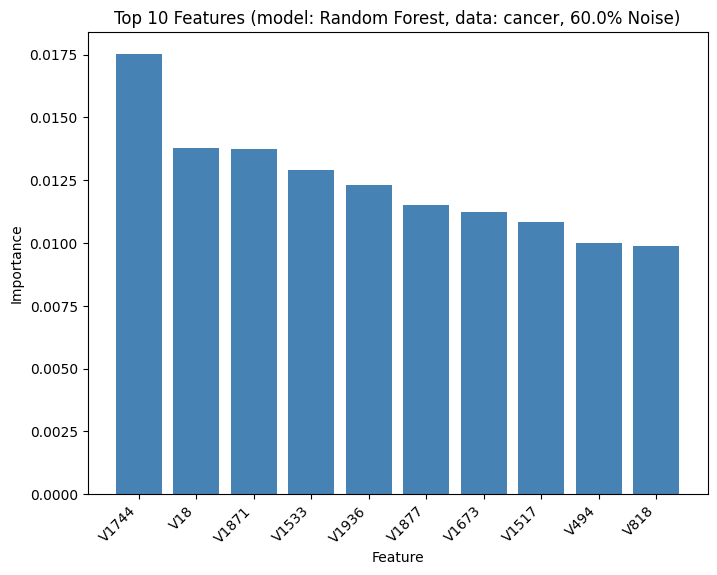

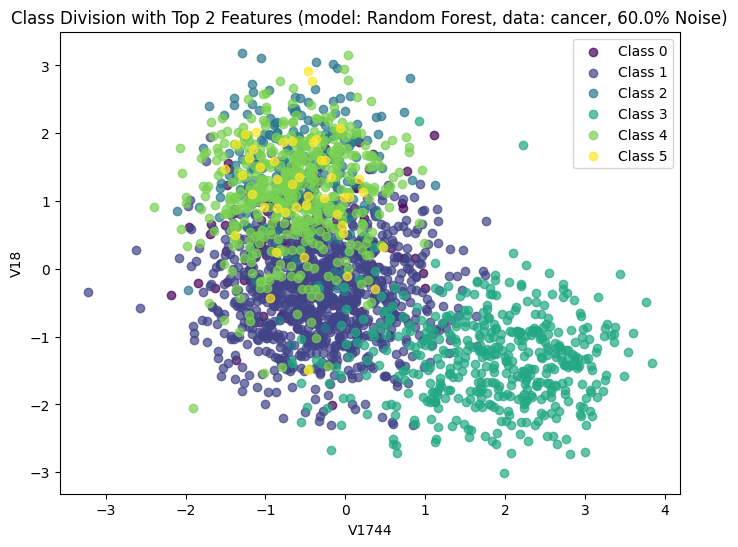

2024-04-29 14:45:49,671 - INFO - Task 4 completed with result: {'noise': 0.6, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.9541165240926007, 'f1_score': 0.9696204089402115}
2024-04-29 14:45:49,671 - INFO - Summary of results:
2024-04-29 14:45:49,672 - INFO - Noise: 0.9, Balanced Accuracy Score: 0.

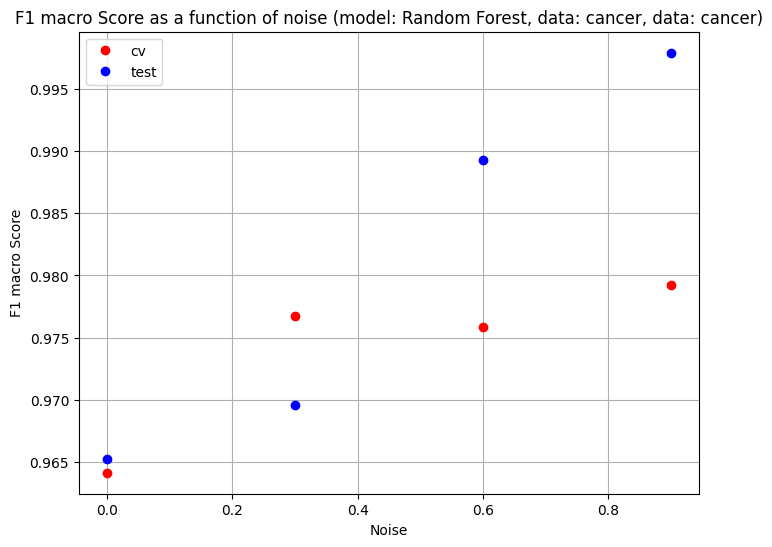

2024-04-29 14:45:49,809 - INFO - All tasks completed.


CPU times: user 53.1 s, sys: 1.42 s, total: 54.6 s
Wall time: 1min 53s


In [16]:
%%time

results_cancer_rf = main_parallel('rf', 'cancer')

In [17]:
%%time

# reduce the number of paramter in the grid search for Gradient Boosting with
# the cancer dataset
n_estimators = [15, 50, 100, 150]
max_depth = [3, 5, 10]
learning_rate = [0.1, 0.3, 0.5]
params_gb = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__learning_rate': learning_rate,
}
results_cancer_gb = main_parallel('gb', 'cancer')

# reset the parameter grid for Gradient Boosting
n_estimators = [15, 50, 100, 150, 250]
max_depth = [None, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.5]
params_gb = {
  'classifier__n_estimators': n_estimators,
  'classifier__max_depth': max_depth,
  'classifier__learning_rate': learning_rate,
}

2024-04-29 14:45:49,820 - INFO - Starting main function with model_name: gb
2024-04-29 14:45:49,821 - INFO - Submitting task for noise level: 0
2024-04-29 14:45:49,828 - INFO - Submitting task for noise level: 0.3
2024-04-29 14:45:49,834 - INFO - Submitting task for noise level: 0.6
2024-04-29 14:45:49,857 - INFO - Submitting task for noise level: 0.9
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2024-04-29 00:53:13,068 - INFO - Starting main function with model_name: rf
2024-04-29 00:53:13,070 - INFO - Submitting task for noise level: 0
2024-04-29 00:53:13,071 - INFO - Submitting task for noise level: 0.3
2024-04-29 00:53:13,073 - INFO - Submitting task for noise level: 0.6
2024-04-29 00:53:13,075 - INFO - Submitting task for noise level: 0.9


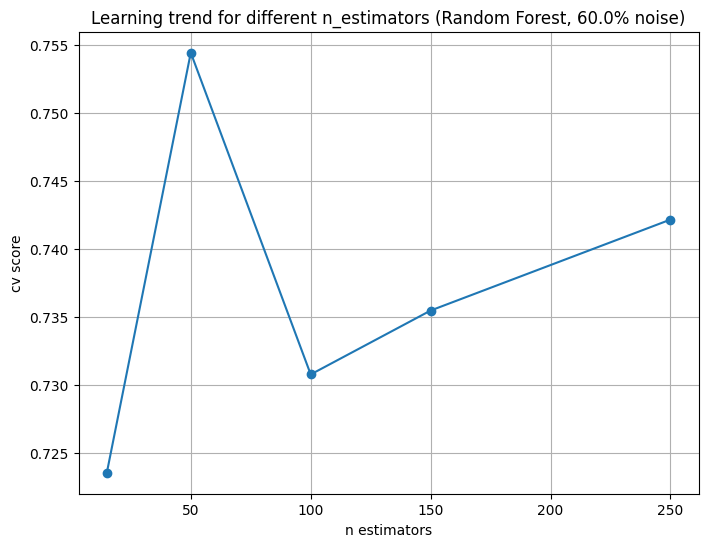

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__max_depth': 5, 'classifier__n_estimators': 50} (Random Forest, noise: 60.0%)
               precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.78      0.70      0.74        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



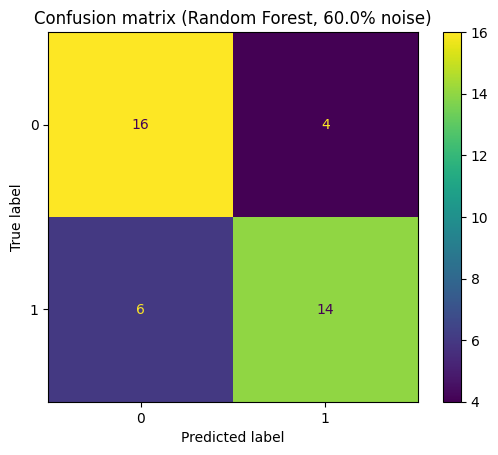

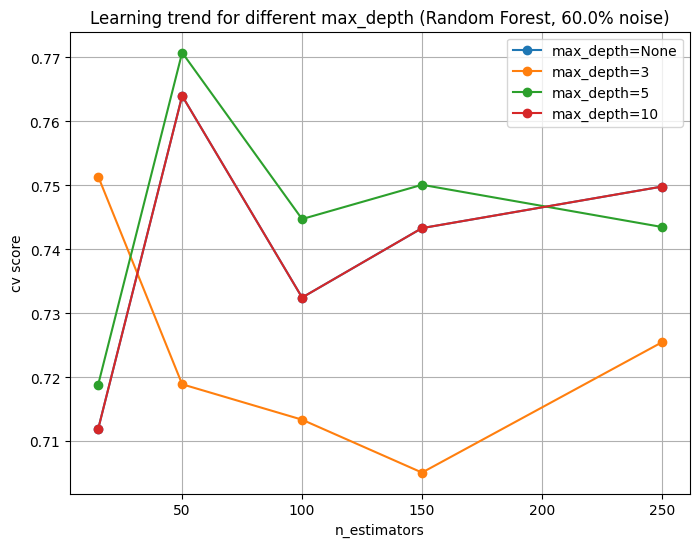

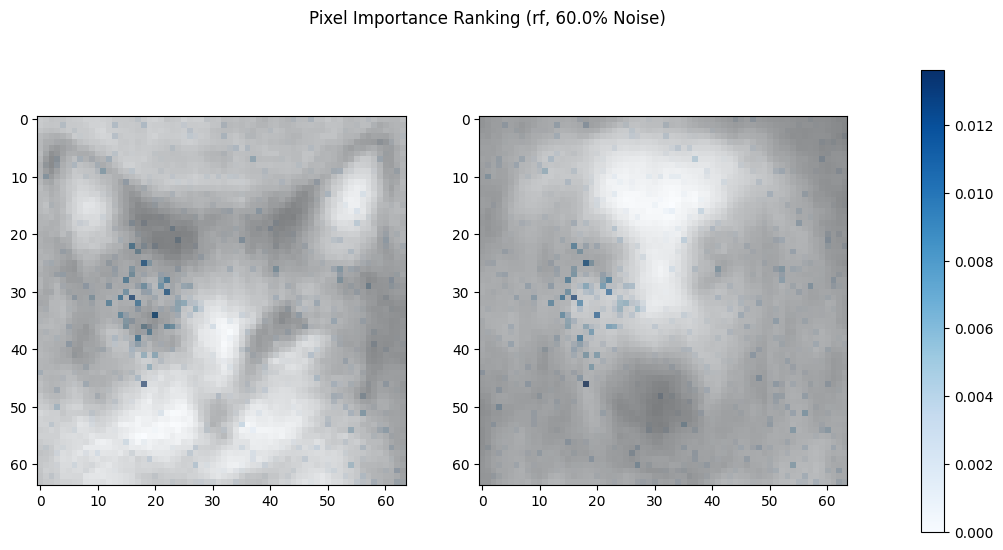

2024-04-29 00:53:27,089 - INFO - Task 1 completed with result: {'noise': 0.6, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.75, 'f1_score': 0.7493734335839599}


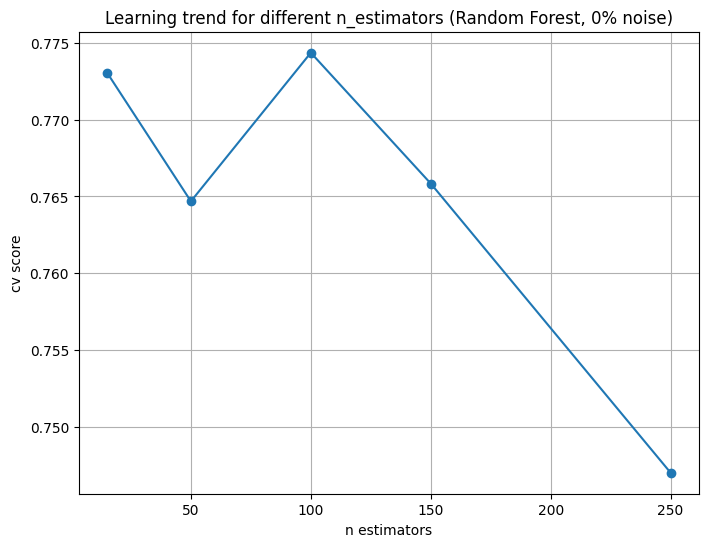

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__max_depth': None, 'classifier__n_estimators': 15} (Random Forest, noise: 0%)
               precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.78      0.70      0.74        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



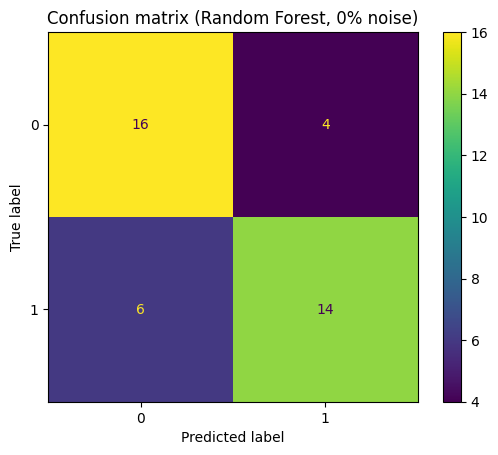

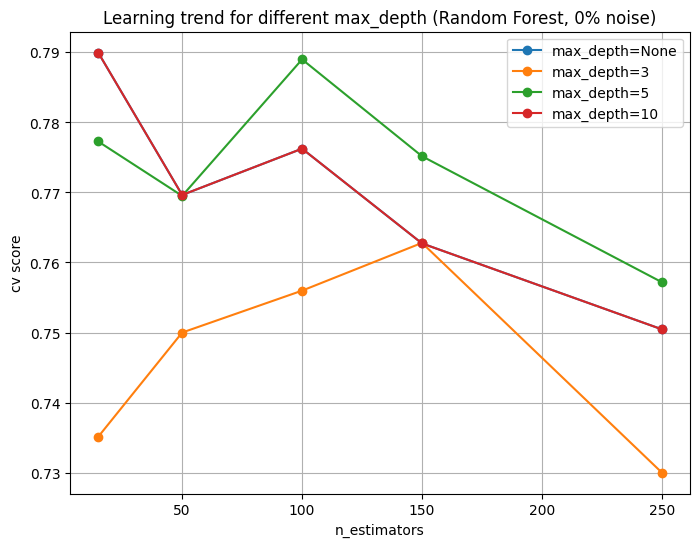

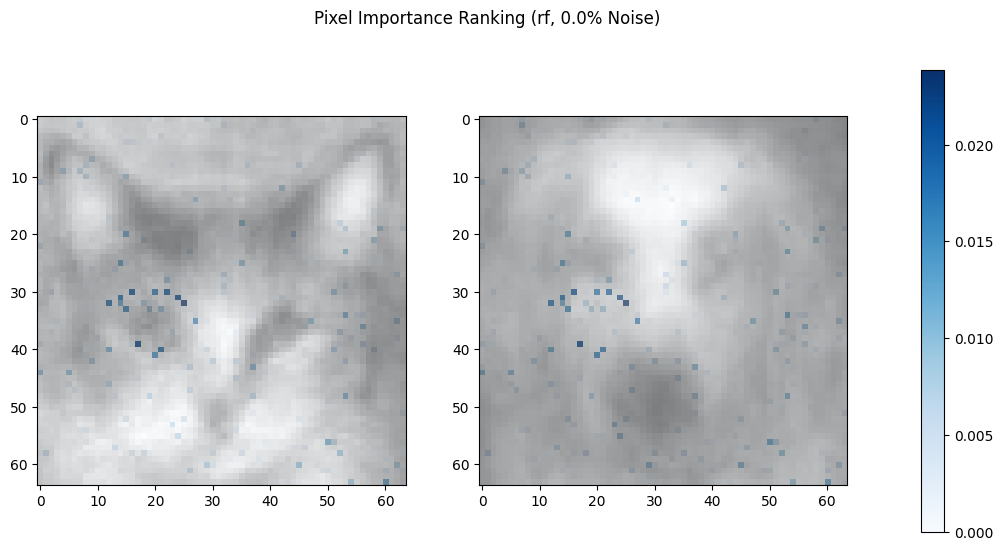

2024-04-29 00:53:27,835 - INFO - Task 2 completed with result: {'noise': 0, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.75, 'f1_score': 0.7493734335839599}


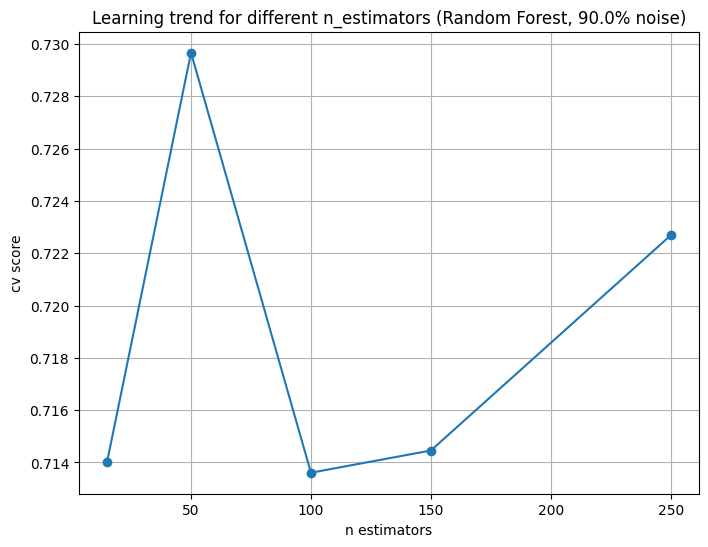

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__max_depth': 5, 'classifier__n_estimators': 250} (Random Forest, noise: 90.0%)
               precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.81      0.65      0.72        20

    accuracy                           0.75        40
   macro avg       0.76      0.75      0.75        40
weighted avg       0.76      0.75      0.75        40



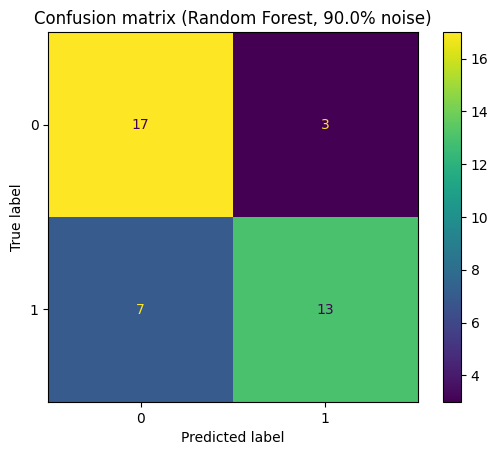

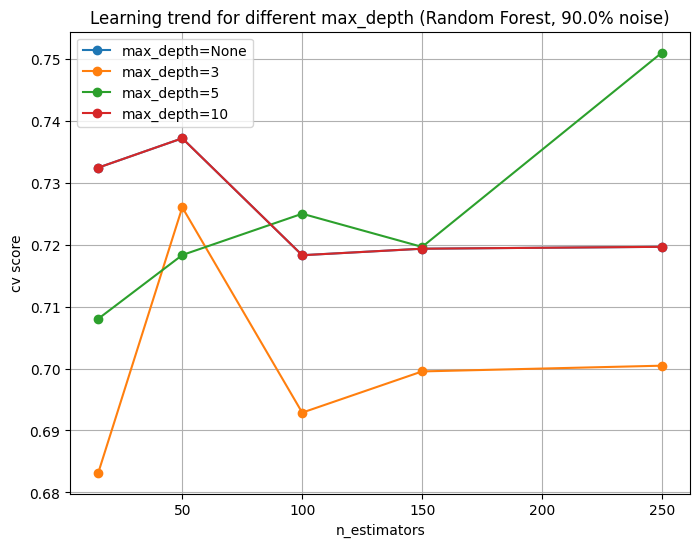

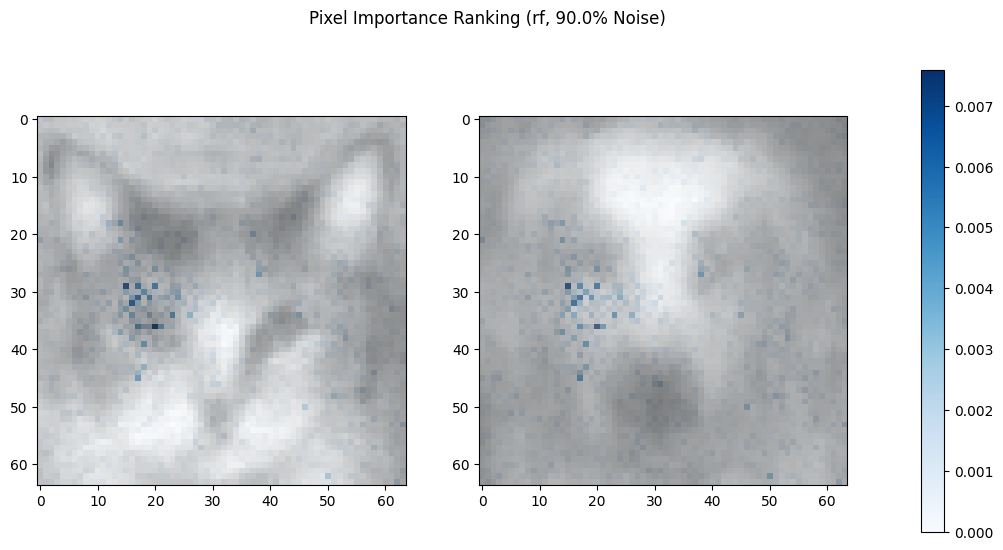

2024-04-29 00:53:28,830 - INFO - Task 3 completed with result: {'noise': 0.9, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.75, 'f1_score': 0.7474747474747474}


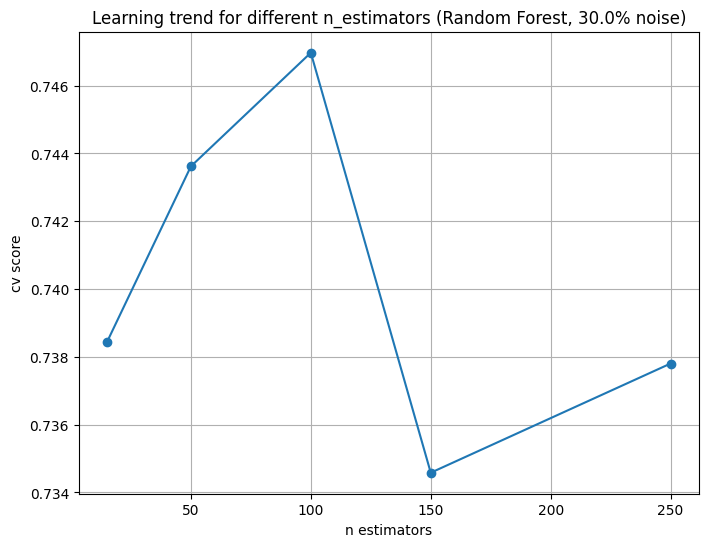

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__max_depth': None, 'classifier__n_estimators': 15} (Random Forest, noise: 30.0%)
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       1.00      0.70      0.82        20

    accuracy                           0.85        40
   macro avg       0.88      0.85      0.85        40
weighted avg       0.88      0.85      0.85        40



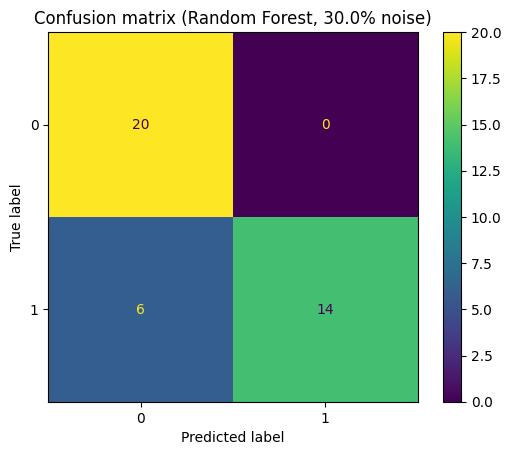

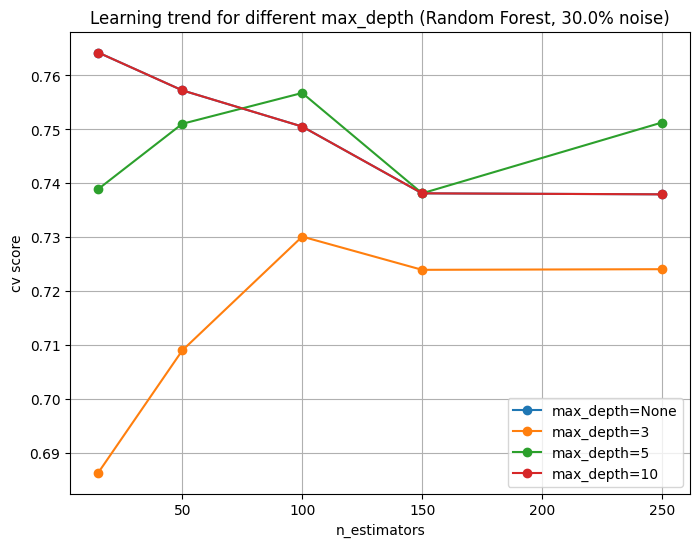

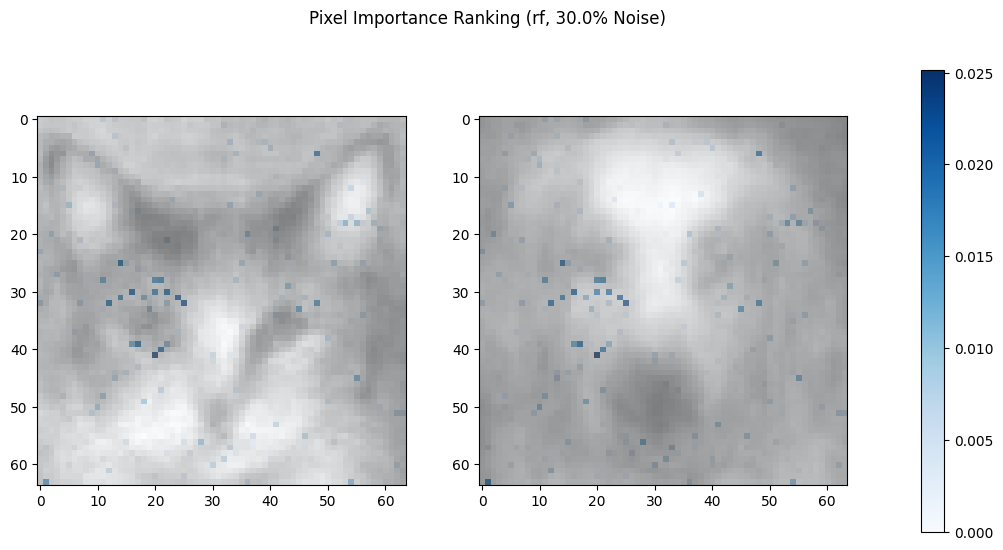

2024-04-29 00:53:29,660 - INFO - Task 4 completed with result: {'noise': 0.3, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 3, 5, 10],
                         'classifier__n_estimators': [15, 50, 100, 150, 250]},
             scoring='f1_macro'), 'balanced_ac_score': 0.85, 'f1_score': 0.8465473145780051}
2024-04-29 00:53:29,660 - INFO - Summary of results:
2024-04-29 00:53:29,661 - INFO - Noise: 0.9, Balanced Accuracy Score: 0.75, F1 Score: 

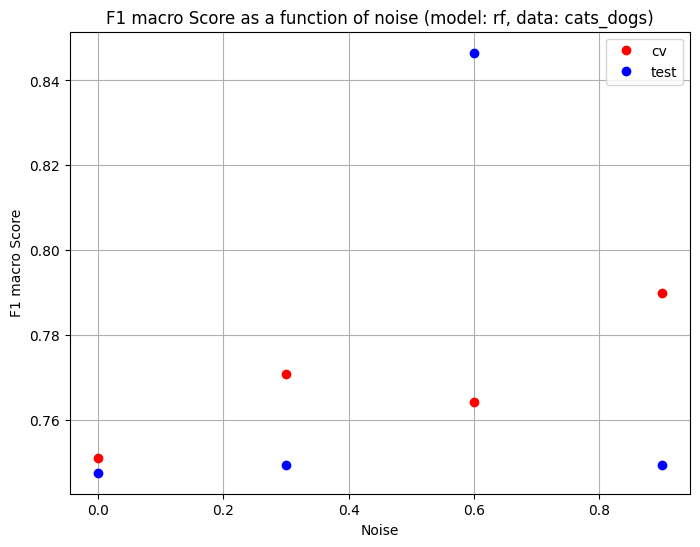

2024-04-29 00:53:29,793 - INFO - All tasks completed.


CPU times: user 6.21 s, sys: 521 ms, total: 6.73 s
Wall time: 16.7 s


In [ ]:
%%time

results_cats_dogs_rf = main_parallel('rf', 'cats_dogs')

2024-04-29 00:53:29,803 - INFO - Starting main function with model_name: gb
2024-04-29 00:53:29,803 - INFO - Submitting task for noise level: 0
2024-04-29 00:53:29,805 - INFO - Submitting task for noise level: 0.3
2024-04-29 00:53:29,816 - INFO - Submitting task for noise level: 0.6
2024-04-29 00:53:29,835 - INFO - Submitting task for noise level: 0.9


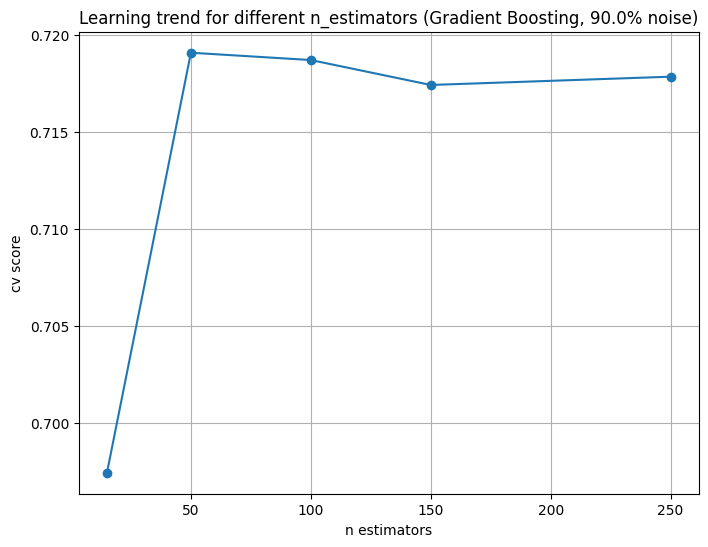

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100} (Gradient Boosting, noise: 90.0%)
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.70      0.70      0.70        20

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



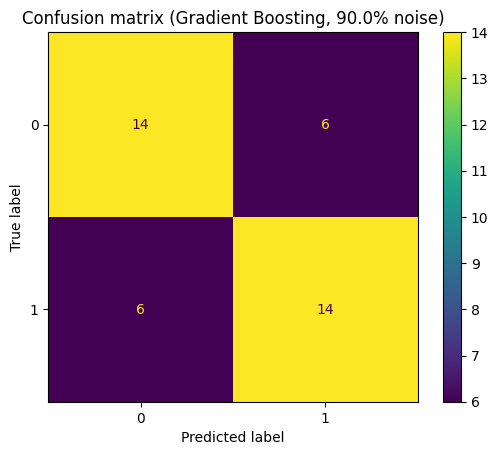

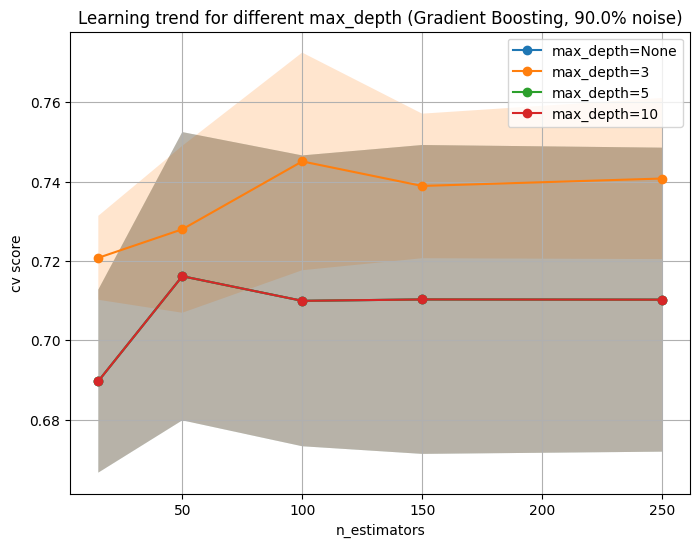

0.05 [0.7014235712274139, 0.7409419994495458, 0.7453852978196164, 0.7519962124802612, 0.7567737240784908]
0.1 [0.7160657105553148, 0.742643915324527, 0.7405270066199955, 0.7283479821901574, 0.7203257917553629]
0.5 [0.6748806392772707, 0.6736788627910351, 0.6702225404196522, 0.6719364603267296, 0.676461784248571]


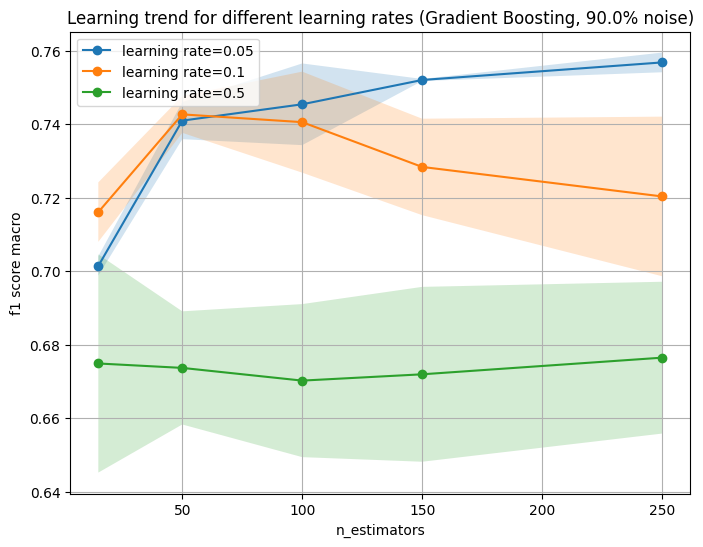

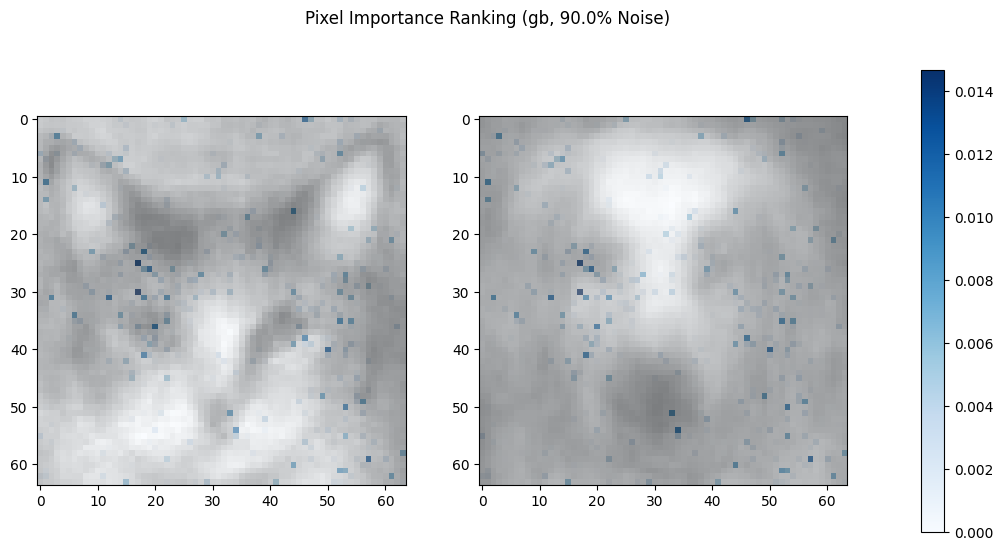

2024-04-29 00:58:59,157 - INFO - Task 1 completed with result: {'noise': 0.9, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.7,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable

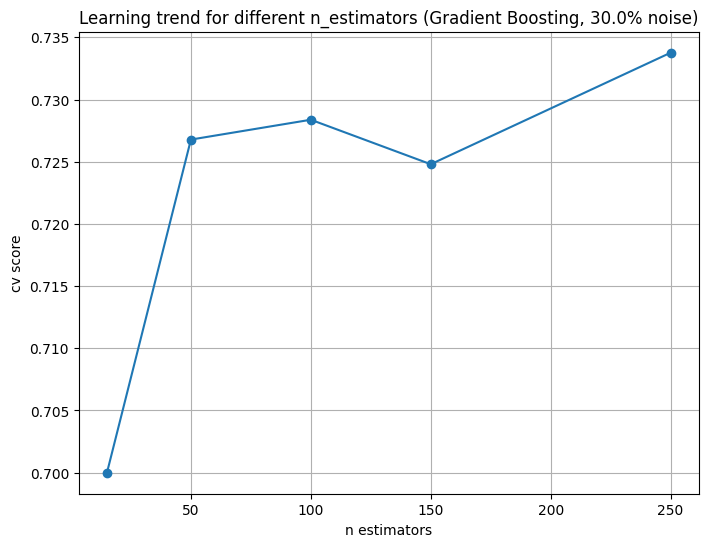

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__learning_rate': 0.5, 'classifier__max_depth': 3, 'classifier__n_estimators': 50} (Gradient Boosting, noise: 30.0%)
               precision    recall  f1-score   support

           0       0.67      0.80      0.73        20
           1       0.75      0.60      0.67        20

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



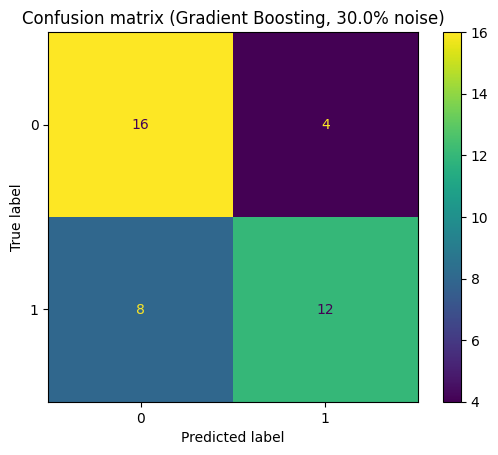

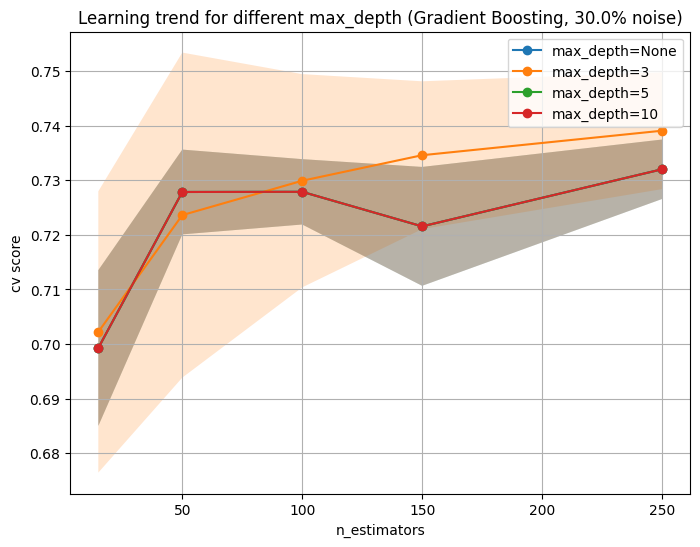

0.05 [0.6858263945694537, 0.7109627163626557, 0.7156579606659493, 0.7094101289002364, 0.7256336944268019]
0.1 [0.6903516301220574, 0.7262038058171892, 0.7330319510271577, 0.7285467471589023, 0.7392180441406202]
0.5 [0.7238100448105032, 0.7431699500546999, 0.7364329023112737, 0.7364329023112737, 0.7364329023112737]


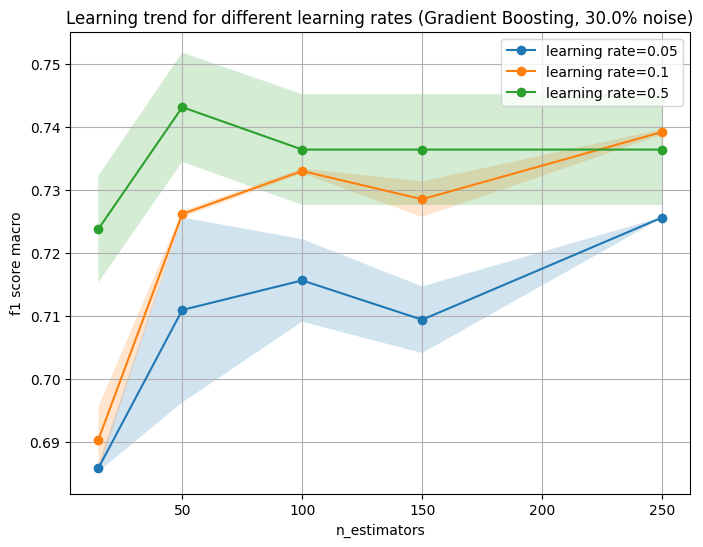

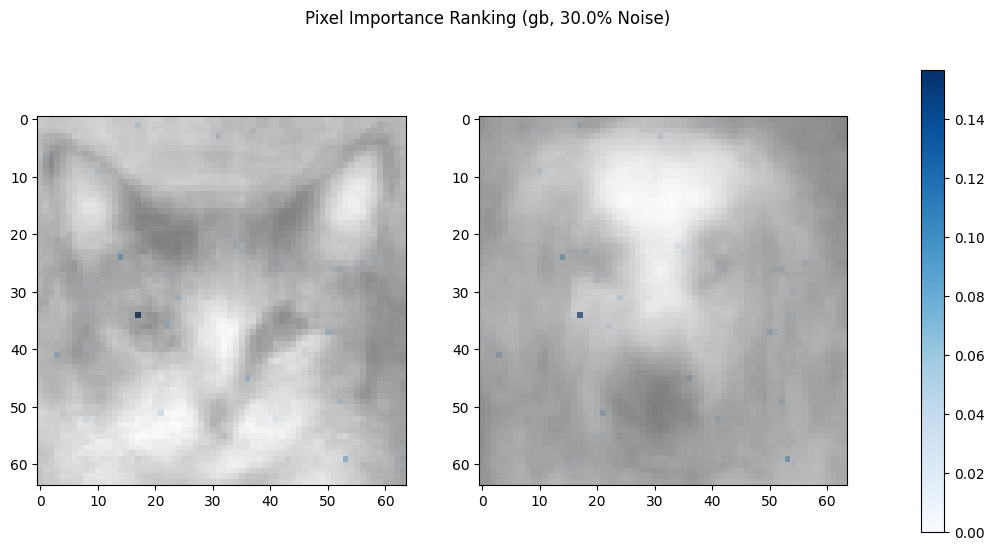

2024-04-29 00:59:01,003 - INFO - Task 2 completed with result: {'noise': 0.3, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.7,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable

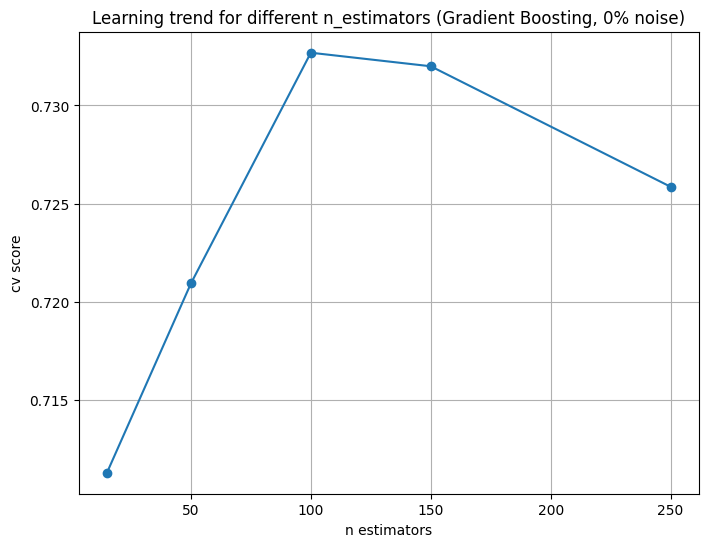

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__learning_rate': 0.05, 'classifier__max_depth': None, 'classifier__n_estimators': 150} (Gradient Boosting, noise: 0%)
               precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.74      0.70      0.72        20

    accuracy                           0.72        40
   macro avg       0.73      0.72      0.72        40
weighted avg       0.73      0.72      0.72        40



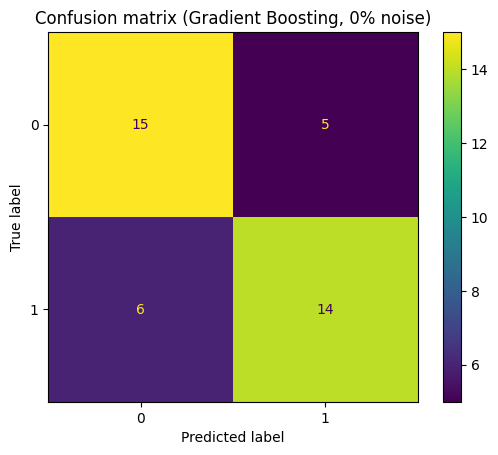

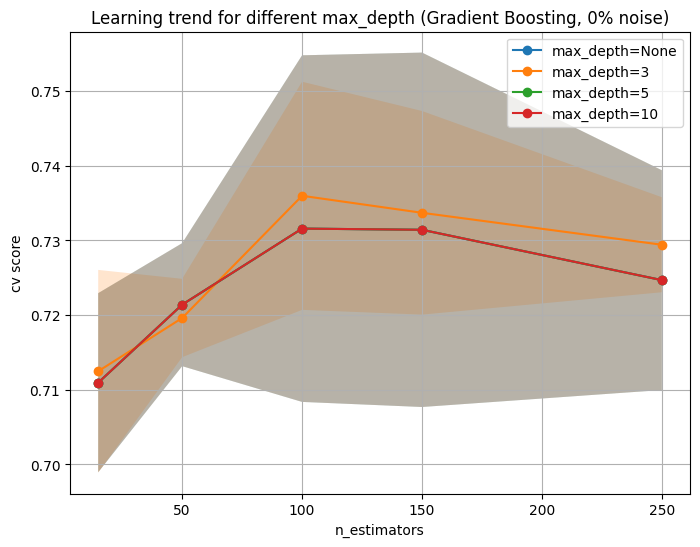

0.05 [0.7201240001730147, 0.7308791395428708, 0.7625215426115247, 0.7615154541934186, 0.7435587555511792]
0.1 [0.6938912076969794, 0.7191012698504452, 0.7204198795054391, 0.7210520774776683, 0.7189271987371701]
0.5 [0.7199409722406821, 0.7128528041088245, 0.7151050002158977, 0.7134116600392149, 0.7151050899800925]


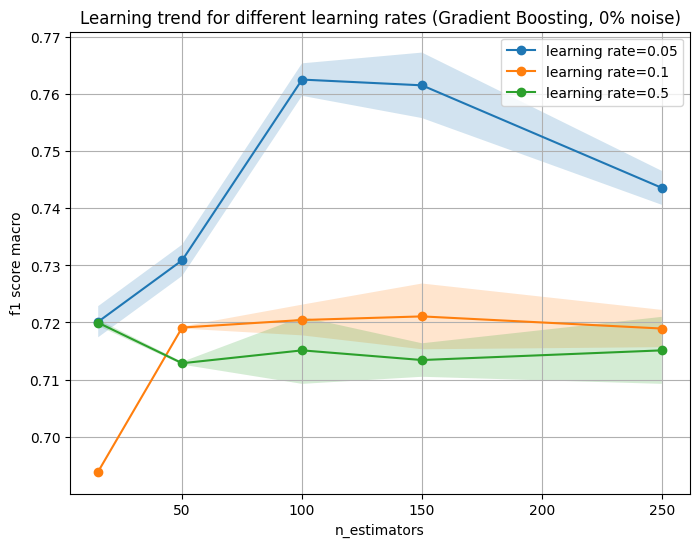

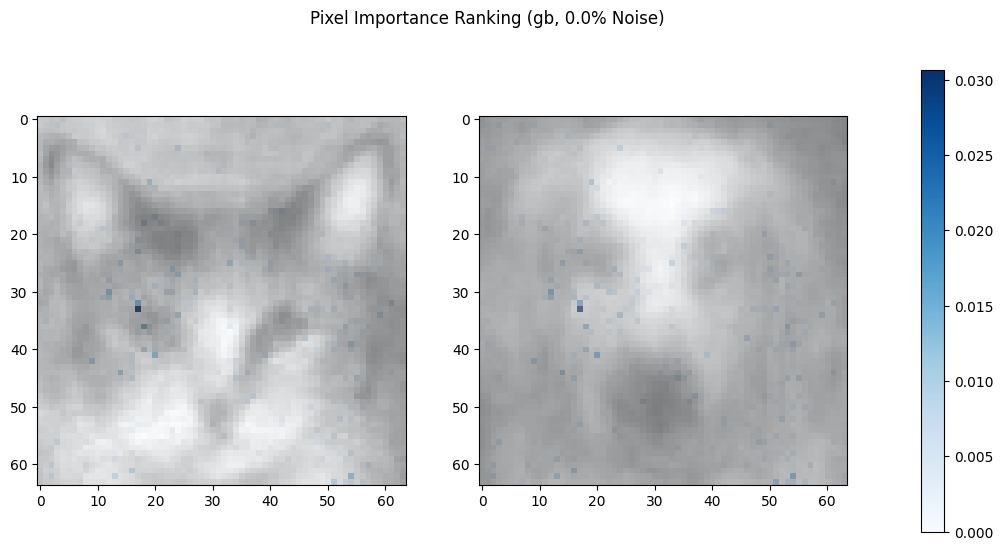

2024-04-29 00:59:02,109 - INFO - Task 3 completed with result: {'noise': 0, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.7,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_c

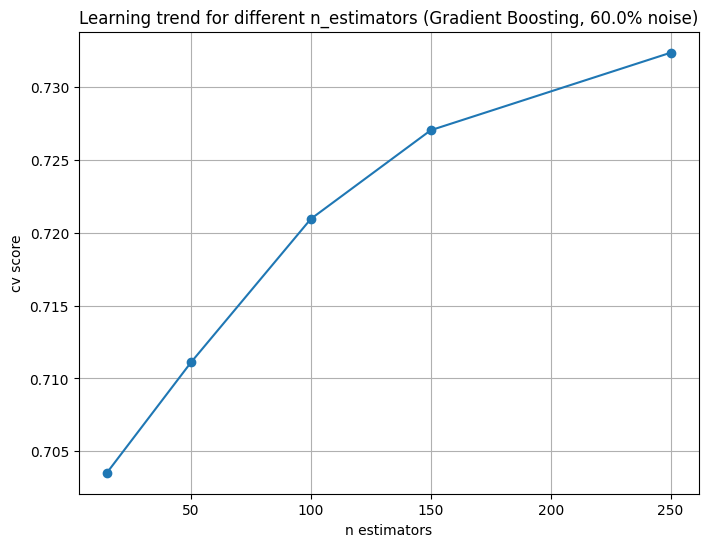

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 250} (Gradient Boosting, noise: 60.0%)
               precision    recall  f1-score   support

           0       0.72      0.90      0.80        20
           1       0.87      0.65      0.74        20

    accuracy                           0.78        40
   macro avg       0.79      0.78      0.77        40
weighted avg       0.79      0.78      0.77        40



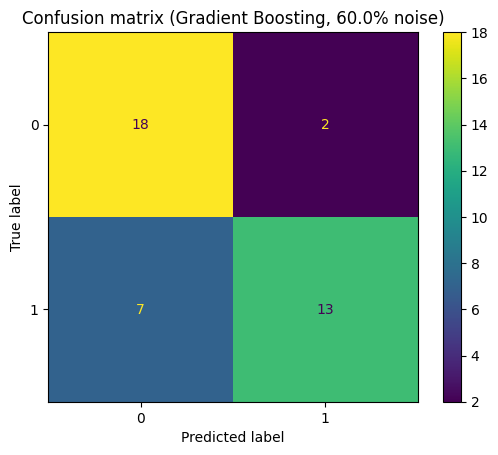

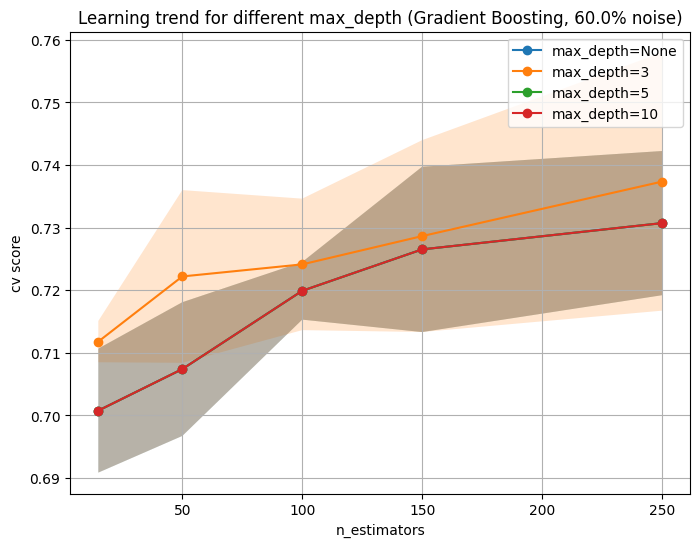

0.05 [0.7088562492084644, 0.7066487930988994, 0.7244401212557972, 0.7404861712699338, 0.7452508285143522]
0.1 [0.6918757666363213, 0.7058996276065865, 0.7240460222772538, 0.7324081521540614, 0.7374154947394532]
0.5 [0.7098516433764934, 0.7207418489397021, 0.7143719086074976, 0.7082363315696649, 0.7144269456034161]


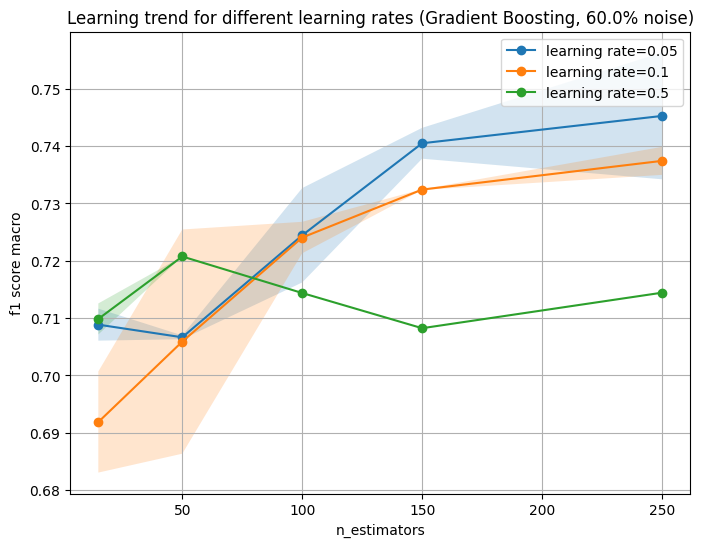

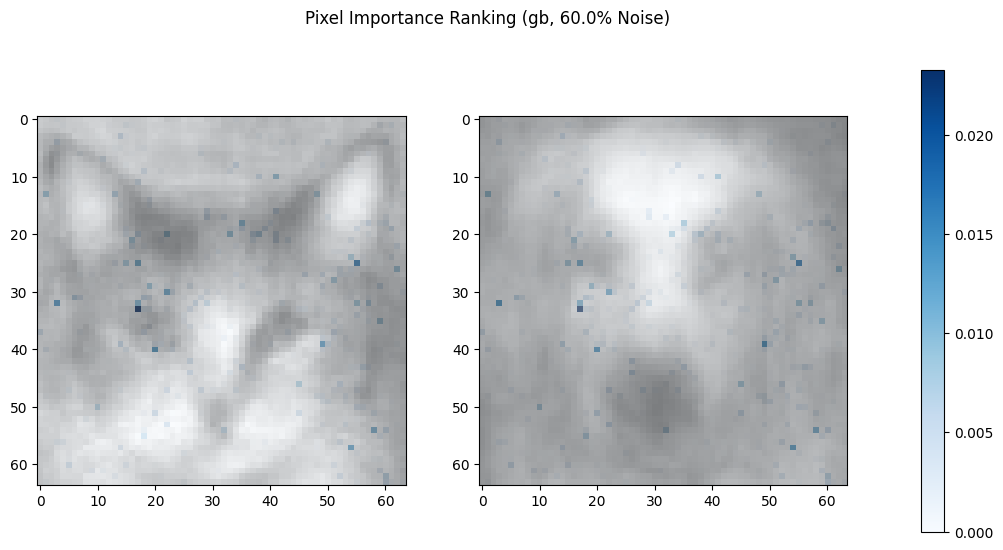

2024-04-29 00:59:02,962 - INFO - Task 4 completed with result: {'noise': 0.6, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.7,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable

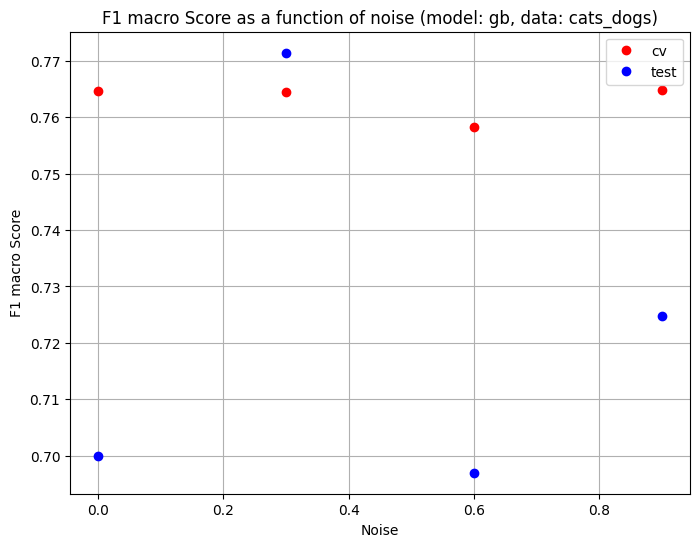

2024-04-29 00:59:03,083 - INFO - All tasks completed.


CPU times: user 1min 40s, sys: 3.9 s, total: 1min 43s
Wall time: 5min 33s


In [ ]:
%%time

results_cats_dogs_gb = main_parallel('gb', 'cats_dogs') 

## Part 2 - break Gradient boosting

In [ ]:
# create the simulated data with reasonable paramter for the task
X_simulated, Y_simulated = make_classification(
  # much more features than samples, to both simualate
  # high-dimenstional dataset and make hader for the model
  # to generalize new patterns
  n_samples=100, 
  n_features=1000,
  
  # 100 informative features, which will be progressibely
  # eliminated to see the effect of missing informative
  # features
  n_informative=100, 
  n_redundant=100, 
  
  # 3 classes, with a level of imbalancy. Also, the value
  # of class_sep is set to 0.7 to make the classes more
  # overlapped 
  n_clusters_per_class=3, 
  weights=[0.1, 0.3, 0.6],
  class_sep=0.6,
  
  random_state=random_state,
)


NameError: name 'make_classification' is not defined

In [ ]:
X_simulated.head()

In [ ]:
Y_simulated.value_counts()

In [ ]:
from sklearn.metrics import f1_score, make_scorer

def train_and_remove_features(X, y, n_estimators, max_depth, learning_rate, n_features_to_remove, noise):
    X_train, X_val, X_test, y_train, y_val, y_test = splits(X, y, noise, validation_set=True)

    train_scores = []
    val_scores = []
    test_scores = []
    
    scorer = make_scorer(f1_score, average='macro')

    for i in range(X.shape[1] // n_features_to_remove):
        pipeline = Pipeline([
            ('variance_threshold', VarianceThreshold()),
            ('classifier', XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42))
        ])
        
        pipeline.fit(X_train, y_train)

        train_score = scorer(y_train, pipeline.predict(X_train))
        val_score = scorer(y_val, pipeline.predict(X_val))
        test_score = scorer(y_test, pipeline.predict(X_test))

        train_scores.append(train_score)
        val_scores.append(val_score)
        test_scores.append(test_score)

        importances = pipeline['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]

        # Remove the top N features
        top_n_features = indices[:n_features_to_remove]
        X_train = X_train.drop(columns=X.columns[top_n_features])
        X_val = X_val.drop(columns=X.columns[top_n_features])
        X_test = X_test.drop(columns=X.columns[top_n_features])
        
        # histogram of the feature importances
        plt.figure(figsize=(8, 6))
        plt.bar(range(len(importances)), importances[indices])
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.title('Feature Importances')
        plt.show()
        
    
    return train_scores, val_scores, test_scores

In [ ]:
train_scores, val_scores, test_scores = train_and_remove_features(X_simulated, Y_simulated, 100, 3, 0.1, 10, 0)

# plot the scores
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_scores)), train_scores, marker='o', label='train')
plt.plot(range(len(val_scores)), val_scores, marker='o', label='validation')
plt.plot(range(len(test_scores)), test_scores, marker='o', label='test')
plt.xlabel('Number of Features Removed')
plt.ylabel('F1 Score Macro')
plt.grid(True)
plt.legend()
plt.title('F1 Score Macro as a function of the number of features removed')
plt.savefig('imgs/simulated_plot_feature_elimination.png')
plt.show()